<a href="https://colab.research.google.com/github/virgiawan/yog2a-melanoma/blob/master/Melanoma_(Wildan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Detection App
---

## Explore the Example Data

Sebelum mengimport data dari Kaggle, kita perlu mendownload API token terlebih dahulu. API token ini bisa kita download dengan cara: **Login di Kaggle > My Account > Home > Create New API Token**. API token ini akan terdownload dalam bentuk file kaggle.json dan harus kita upload ke google colab

In [1]:
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abuwildanm","key":"cf45bfabf4aeb5a95547f59e04a023be"}'}

Supaya dapat mengimport dataset dari Kaggle, jalankan perintah berikut

In [2]:
# Install kaggle library 
!pip install -q kaggle
# Make ".kaggle" directory in root directory
!mkdir -p ~/.kaggle
# Copy the API token to the kaggle directory
!cp kaggle.json ~/.kaggle/
# Check the directory
!ls ~/.kaggle
# Adjust access permissions
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


Setelah itu kita dapat mendownload dataset dari Kaggle dengan perintah berikut

In [3]:
# Download the data
!kaggle datasets download -d drscarlat/melanoma
!unzip -q melanoma.zip -d .
!ls

100% 5.26G/5.26G [01:52<00:00, 35.8MB/s]
100% 5.26G/5.26G [01:52<00:00, 50.0MB/s]
dermmel  DermMel  kaggle.json  melanoma.zip  sample_data


Dataset tersebut berisi beberapa direktori yang menyimpan data untuk training, validation, dan testing. Oleh karena itu, untuk setiap direktori yang ada, kita perlu menyimpan path-nya.

Dataset tersebut juga berisi 2 subdirektori yang mendefinisikan label yaitu `Melanoma` dan `NotMelanoma`. Training set kita gunakan untuk melatih neural network mana gambar yang memiliki penyakit pneumonia atau tidak. Validation set adalah dataset yang belum terlihat sebelumnya oleh neural network sehingga kita bisa menguji performa neural network. Test set adalah dataset yang digunakan untuk menguji kemampuan neural network setelah dilakukan training dan validation.

In [0]:
import os

base_dir = '/content/DermMel'

train_dir = os.path.join(base_dir, 'train_sep')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Label
melanoma = 'Melanoma'
not_melanoma = 'NotMelanoma'

# Train dataset directory
train_melanoma_dir = os.path.join(train_dir, melanoma)
train_not_melanoma_dir = os.path.join(train_dir, not_melanoma)

# Validation dataset directory
validation_melanoma_dir = os.path.join(validation_dir, melanoma)
validation_not_melanoma_dir = os.path.join(validation_dir, not_melanoma)

# Test dataset directory
test_melanoma_dir = os.path.join(test_dir, melanoma)
test_not_melanoma_dir = os.path.join(test_dir, not_melanoma)

In [5]:
train_melanoma_fnames = os.listdir(train_melanoma_dir)
train_not_melanoma_fnames = os.listdir(train_not_melanoma_dir)

print(train_melanoma_fnames[:10])
print(train_not_melanoma_fnames[:10])

['AUG_0_7111.jpeg', 'AUGmented_0_6791.jpeg', 'AUG_0_4154.jpeg', 'AUG_0_33.jpeg', 'AUG_0_2766.jpeg', 'ISIC_0027130.jpg', 'AUG_0_3241.jpeg', 'AUG_0_1228.jpeg', 'ISIC_0027797.jpg', 'AUG_0_5931.jpeg']
['ISIC_0028542.jpg', 'ISIC_0026965.jpg', 'ISIC_0028224.jpg', 'ISIC_0025114.jpg', 'ISIC_0028142.jpg', 'ISIC_0024335.jpg', 'ISIC_0025517.jpg', 'ISIC_0031127.jpg', 'ISIC_0029494.jpg', 'ISIC_0028231.jpg']


In [6]:
# Create test directory which contains only 100 images
test_100_dir = os.path.join(base_dir, 'test_100')
try: 
    os.makedirs(test_100_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(test_100_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(test_100_dir))

# Create test melanoma directory which contains only 50 images 
test_100_melanoma_dir = os.path.join(test_100_dir, melanoma)
try: 
    os.makedirs(test_100_melanoma_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(test_100_melanoma_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(test_100_melanoma_dir))

# Create test not melanoma directory which contains only 50 images
test_100_not_melanoma_dir = os.path.join(test_100_dir, not_melanoma)
try: 
    os.makedirs(test_100_not_melanoma_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(test_100_not_melanoma_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(test_100_not_melanoma_dir))

Directory /content/DermMel/test_100 created successfully
Directory /content/DermMel/test_100/Melanoma created successfully
Directory /content/DermMel/test_100/NotMelanoma created successfully


In [0]:
from shutil import copy

# Obtain 50 image fnames from test melanoma and not melanoma dir
test_melanoma_fnames = os.listdir(test_melanoma_dir)[:50]
test_not_melanoma_fnames = os.listdir(test_not_melanoma_dir)[:50]

# Obtain 50 image path from test melanoma and not melanoma dir
test_melanoma_path = [os.path.join(test_melanoma_dir, fname) for fname in test_melanoma_fnames]
test_not_melanoma_path = [os.path.join(test_not_melanoma_dir, fname) for fname in test_not_melanoma_fnames]

# Copy 50 images of melanoma and not melanoma from test directory to test_100 directory
for melanoma_path, not_melanoma_path in zip(test_melanoma_path, test_not_melanoma_path):
    copy(melanoma_path, test_100_melanoma_dir)
    copy(not_melanoma_path, test_100_not_melanoma_dir)

In [8]:
total_train = len(os.listdir(train_melanoma_dir)) + len(os.listdir(train_not_melanoma_dir))
total_validation = len(os.listdir(validation_melanoma_dir)) + len(os.listdir(validation_not_melanoma_dir))
total_test = len(os.listdir(test_melanoma_dir)) + len(os.listdir(test_not_melanoma_dir))
total_test_100 = len(os.listdir(test_100_not_melanoma_dir)) + len(os.listdir(test_100_not_melanoma_dir))

print('Total training melanoma images:', len(os.listdir(train_melanoma_dir)))
print('Total training not melanoma images:', len(os.listdir(train_not_melanoma_dir)))
print('Total training images:', total_train)
print()
print('Total validation melanoma images:', len(os.listdir(validation_melanoma_dir)))
print('Total validation not melanoma images:', len(os.listdir(validation_not_melanoma_dir)))
print('Total validation images:', total_validation)
print()
print('Total testing melanoma images:', len(os.listdir(test_melanoma_dir)))
print('Total testing not melanoma images:', len(os.listdir(test_not_melanoma_dir)))
print('Total testing images:', total_test)
print()
print('Total testing melanoma images (short):', len(os.listdir(test_100_melanoma_dir)))
print('Total testing not melanoma images (short):', len(os.listdir(test_100_not_melanoma_dir)))
print('Total testing images (short):', total_test_100)

Total training melanoma images: 5341
Total training not melanoma images: 5341
Total training images: 10682

Total validation melanoma images: 1781
Total validation not melanoma images: 1781
Total validation images: 3562

Total testing melanoma images: 1781
Total testing not melanoma images: 1780
Total testing images: 3561

Total testing melanoma images (short): 50
Total testing not melanoma images (short): 50
Total testing images (short): 100


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20
target_size = (224, 224)

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
# train_datagen = ImageDataGenerator(rescale = 1.0/255)
validation_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagen  = ImageDataGenerator(rescale = 1.0/255)

# Specify the image classes
classes = ['NotMelanoma', 'Melanoma']

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    classes=classes,
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using validation_datagen generator
# --------------------
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=batch_size,
                                                              class_mode='binary',
                                                              classes=classes,
                                                              target_size=target_size)
# --------------------
# Flow testing images in batches of 100 using test_datagen generator
# --------------------
test_generator = test_datagen.flow_from_directory(test_100_dir,
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  classes=classes,
                                                  target_size=target_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [47]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'NotMelanoma': 0, 'Melanoma': 1}
{'NotMelanoma': 0, 'Melanoma': 1}
{'NotMelanoma': 0, 'Melanoma': 1}


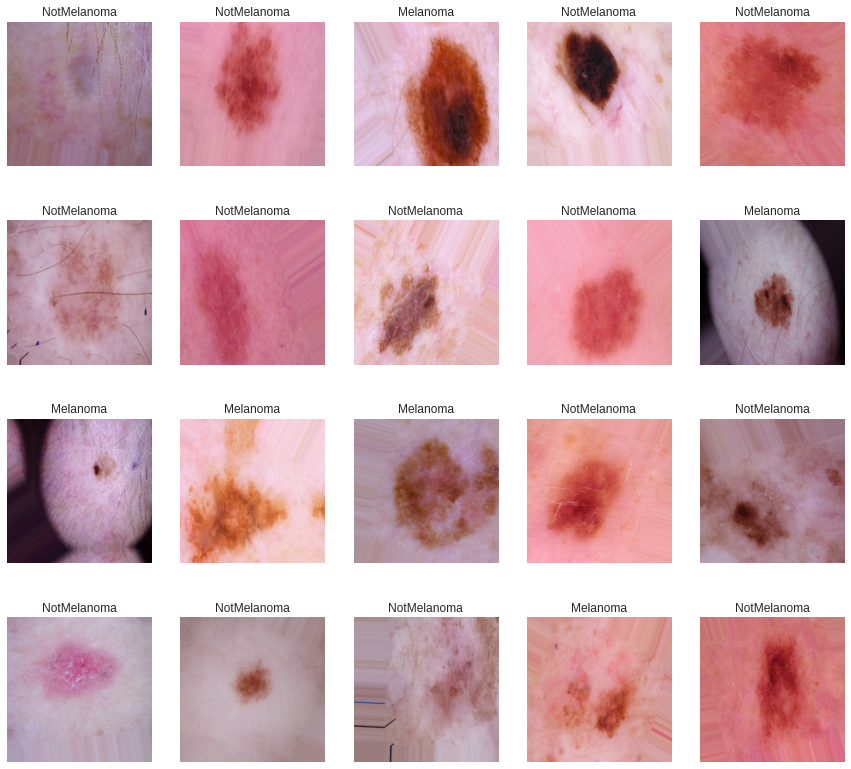

In [48]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf

# Obtain one batch of testing images
images, labels = next(train_generator)
labels = labels.astype('int')

# Plot the images in the batch, along with predicted and true labels
nrows = 4
ncols = batch_size / nrows
fig = plt.figure(figsize=(15, 14))
for idx in range(20):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Build the Model

In [49]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, Xception, DenseNet121

pretrained_model = InceptionV3(input_shape=(224,224,3), include_top=False)
pretrained_model.trainable = False

print(pretrained_model.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [50]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, ReLU, Add, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop, SGD
from tensorflow.keras.metrics import Precision, Recall

# Baseline
# model = Sequential()
# model.add(pretrained_model)
# model.add(Flatten())
# # model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# Improvement InceptionV3 1
last_layer = pretrained_model.get_layer('mixed9')
x = Flatten()(last_layer.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(pretrained_model.input, x)

# Improvement InceptionV3 2

metrics = ['accuracy', Precision(), Recall()]
model.compile(optimizer=Adam(learning_rate=1e-03), loss='binary_crossentropy', metrics=metrics)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [51]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

# callbacks = myCallback()

# Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-04)
# Callback that records events into a History object
hist = History()

# Create checkpoint directory to save the model
checkpoint_dir = './checkpoint'
checkpoint_filepath = os.path.join(checkpoint_dir, 'model-{epoch:02d}-{val_accuracy:.2f}')
try: 
    os.makedirs(checkpoint_dir, exist_ok=True) 
    print('Directory {} created successfully'.format(checkpoint_dir)) 
except OSError as error: 
    print('Directory {} cannot be created'.format(checkpoint_dir))

# Callback to save the model at some frequency
model_checkpoint = ModelCheckpoint(checkpoint_filepath, 
                                   monitor='val_loss', 
                                   save_best_only=True)

Directory ./checkpoint created successfully


In [52]:
from tensorflow.keras.models import save_model, load_model

# -----------------------------------------------------------------------------
#              If you have saved model, comment this block of code
# -----------------------------------------------------------------------------
history = None
# Check the checkpoint directory
if os.path.exists(checkpoint_dir):
    # If the checkpoint directory is empty, then train the model
    if len(os.listdir(checkpoint_dir)) == 0:
        history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=total_train // batch_size,
                            epochs=10,
                            validation_steps=total_validation // batch_size,
                            callbacks=[early_stopping, reduce_lr, model_checkpoint, hist],
                            verbose=2)
        model.save('InceptionV3.h5')
    else:
        best_model_dir = os.listdir(checkpoint_dir)[-1]
        best_model = os.path.join(checkpoint_dir, best_model_dir)
        model = load_model(best_model)
else:
    print('The checkpoint directory cannot be found')
# -----------------------------------------------------------------------------

# Load saved model from path
# saved_model_path = './InceptionV3.h5'
# model = load_model(saved_model_path)

Epoch 1/10
INFO:tensorflow:Assets written to: ./checkpoint/model-01-0.92/assets
534/534 - 1683s - loss: 0.3525 - accuracy: 0.8814 - precision_1: 0.8894 - recall_1: 0.8710 - val_loss: 0.1946 - val_accuracy: 0.9244 - val_precision_1: 0.9510 - val_recall_1: 0.8949 - lr: 0.0010
Epoch 2/10
534/534 - 1681s - loss: 0.2156 - accuracy: 0.9121 - precision_1: 0.9286 - recall_1: 0.8929 - val_loss: 0.2016 - val_accuracy: 0.9242 - val_precision_1: 0.9935 - val_recall_1: 0.8539 - lr: 0.0010
Epoch 3/10
INFO:tensorflow:Assets written to: ./checkpoint/model-03-0.93/assets
534/534 - 1729s - loss: 0.2055 - accuracy: 0.9196 - precision_1: 0.9393 - recall_1: 0.8972 - val_loss: 0.1697 - val_accuracy: 0.9264 - val_precision_1: 0.9352 - val_recall_1: 0.9162 - lr: 0.0010
Epoch 4/10
INFO:tensorflow:Assets written to: ./checkpoint/model-04-0.94/assets
534/534 - 1712s - loss: 0.1901 - accuracy: 0.9233 - precision_1: 0.9432 - recall_1: 0.9008 - val_loss: 0.1561 - val_accuracy: 0.9351 - val_precision_1: 0.9569 - val

In [53]:
model.evaluate(test_generator)

5/5 [==============================] - 8s 2s/step - loss: 0.2292 - accuracy: 0.9200 - precision_1: 1.0000 - recall_1: 0.8400


[0.2291848361492157, 0.9200000166893005, 1.0, 0.8399999737739563]

Notes:

1. VGG16
   - Epoch = 15
   - Start = 87% val_accuracy
   - End = 90% val_accuracy

2. VGG19
   - Epoch = 15
   - Start = 85% val_accuracy
   - End = 91% val_accuracy
   - Train accurracy decrease ==> weakness

3. MobileNet
   - Epoch = 9
   - Start = 92% val_accuracy
   - End = 94% val_accuracy

4. MobileNetV2
   - Epoch = 10
   - Start = 93% val_accuracy
   - End = 93% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

5. InceptionV3
   - Epoch = 9
   - Start = 92% val_accuracy
   - End = 92% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

6. InceptionResNetV2
   - Epoch = 11
   - Start = 87% val_accuracy
   - End = 90% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train accuracy < valid accuracy ==> weakness
   - Train and valid loss decrease ==> advantage

7. Xception
   - Epoch = 8
   - Start = 92% val_accuracy
   - End = 93% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train and valid loss decrease ==> advantage

8. DenseNet121
   - Epoch = 11
   - Start = 94% val_accuracy
   - End = 94% val_accuracy
   - Train accuracy increase and valid accuracy stable ==> advantage
   - Train loss decrease and valid loss increase ==> weakness

9. ResNet50
   - Epoch = 6
   - Start = 50% val_accuracy
   - End = 49% val_accuracy

In [0]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'precision_1', 'recall_1']
    fig = plt.figure(figsize=(15,10))
    for i, metric in enumerate(metrics):
        name = metric.replace('_',' ').capitalize()
        nrows = 2
        ncols = len(metrics) // nrows if (len(metrics) % 2 == 0) else len(metrics) // nrows + 1

        plt.subplot(nrows, ncols, i+1)
        plt.plot(history.epoch, history.history[metric], color='r', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='b', label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Training and validation {}'.format(metric))
        plt.legend()
        plt.tight_layout()

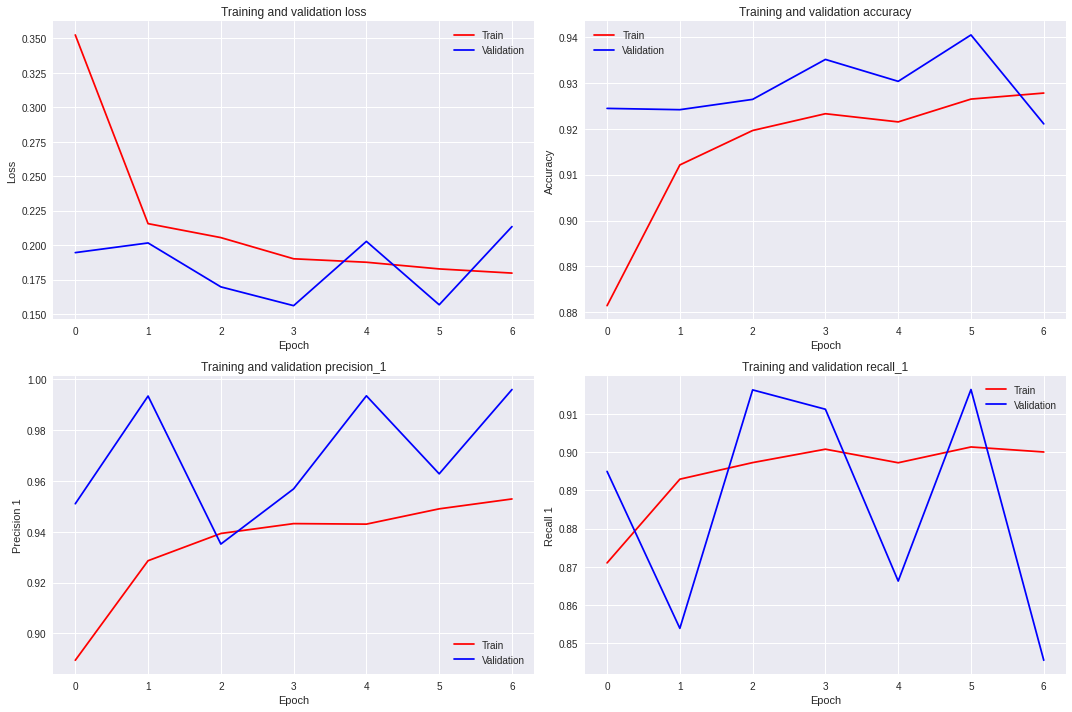

In [102]:
plot_metrics(history)

## Model Evaluation

In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def load_image(path, target_size=(224,224)):
    # Load image from image path
    img = load_img(path, target_size=target_size)
    # Convert image to array
    img = img_to_array(img)
    # Rescale image
    # img = img.astype('float') / 255
    # Add batch dimension
    img = tf.expand_dims(img, axis=0)

    return img

def predict(path):
    # Load single image
    img = load_image(path)
    # Predict the probability of image, return array of array
    pred = model.predict(img)

    # Probability of sigmoid function, 0.5 is threshold
    if pred[0,0] > 0.5:
        return 'Not Melanoma'
    else:
        return 'Melanoma'

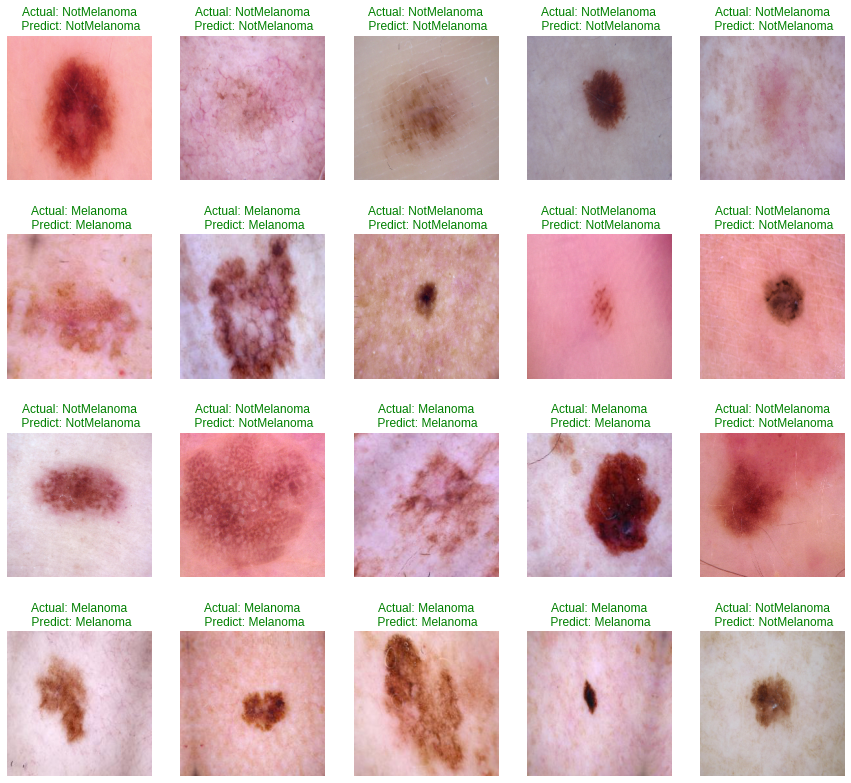

In [154]:
# Obtain one batch of testing images
dataiter = iter(test_generator)
images, labels = dataiter.next()
labels = labels.astype('int')

# Predict the sample images
output = model.predict(images)
# Flatten the numpy array
output = output.squeeze()
# Convert output probabilities to predicted class
preds = tf.where(output > 0.5, 1, 0).numpy()

# Plot the images in the batch, along with predicted and true labels
nrows = 4
ncols = batch_size / nrows
fig = plt.figure(figsize=(15, 14))
for idx in range(20):
    ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    ax.set_title('Actual: {}\n Predict: {}'.format(classes[labels[idx]], classes[preds[idx]]),
                 color=('green' if preds[idx] == labels[idx] else 'red'))

In [0]:
import seaborn as sns

def plot_confusion_matrix(labels, preds):
    conf_matrix = tf.math.confusion_matrix(labels, preds).numpy()

    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True, ax=ax, cmap='Blues');

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(classes);
    ax.yaxis.set_ticklabels(classes);

    print('True Negative (TN):', conf_matrix[0, 0])
    print('False Positive (FP):', conf_matrix[0, 1])
    print('False Negative (FN):', conf_matrix[1, 0])
    print('True Positive (TP):', conf_matrix[1, 1])

Confusion matrix (sample images)
True Negative (TN): 12
False Positive (FP): 0
False Negative (FN): 0
True Positive (TP): 8


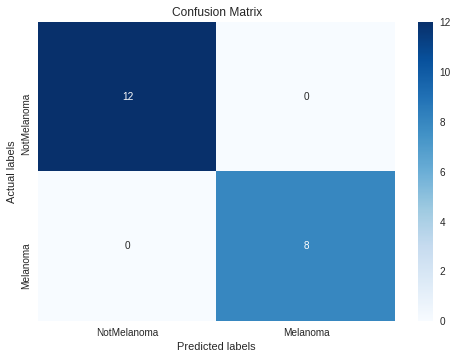

In [156]:
print('Confusion matrix (sample images)')
plot_confusion_matrix(labels, preds)

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(name, labels, output_probabilities, **kwargs):
    fp, tp, _ = roc_curve(labels, output_probabilities)

    fig = plt.figure(figsize=(10,10))
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend(loc='lower right')

    print('AUC Score:', roc_auc_score(labels, output_probabilities))

AUC Score: 1.0


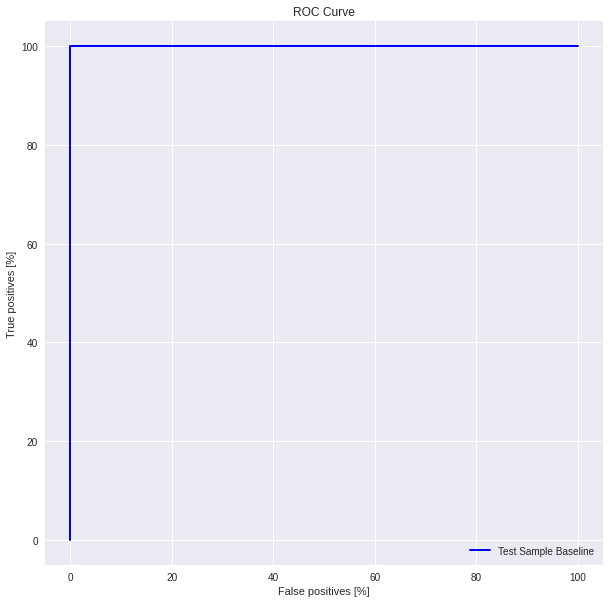

In [158]:
plot_roc('Test Sample Baseline', labels, output, color='b')

In [0]:
labels = test_generator.classes

# Predict the test images
output = model.predict(test_generator)
# Flatten the numpy array
output = output.squeeze()
# Convert output probabilities to predicted class
preds = tf.where(output > 0.5, 1, 0).numpy()

Confusion matrix (full test images)
True Negative (TN): 31
False Positive (FP): 19
False Negative (FN): 27
True Positive (TP): 23


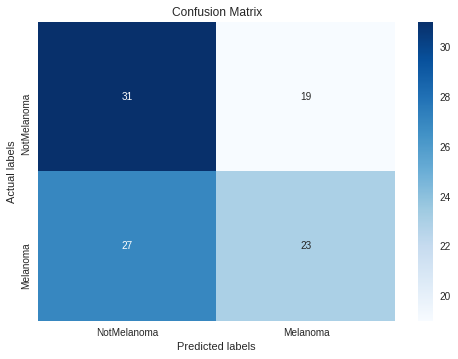

In [160]:
print('Confusion matrix (full test images)')
plot_confusion_matrix(labels, preds)

AUC Score: 0.5012


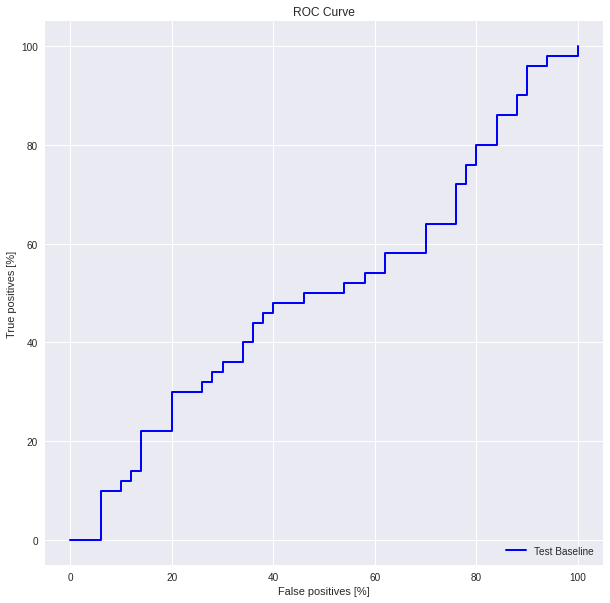

In [161]:
plot_roc('Test Baseline', labels, output, color='b')